In [46]:
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [68]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

# in vitro dataset
metadata = pd.read_csv("datasets/MPS/metadata_MPS.csv")
X_MPS = pd.read_csv("datasets/MPS/X_MPS.csv", index_col=0) # genes on the columns, samples on the rows
Y_viper_MPS = pyreadr.read_r("datasets/MPS/Y_viper_MPS.rds")[None]

In [5]:
metadata

,Unnamed: 0,X,sampleName,condition,treatment,batch,NPC,Background,Number_of_cues,Combination_name,TGF,LPS,Cholesterol,Fructose,Background.1,NPC.1
0,NAFT18012_P1A1_D14_49_S18,NAFT18012_P1A1_D14_49_S18,NAFT18012_P1A1_D14_49_S18,Lean_control,Lean,batch1,high,lean,0,Control,False,False,False,False,lean,high
1,NAFT18012_P1A2_D14_50_S21,NAFT18012_P1A2_D14_50_S21,NAFT18012_P1A2_D14_50_S21,Lean_control,Lean,batch1,high,lean,0,Control,False,False,False,False,lean,high
2,NAFT18012_P1A3_D14_51_S1,NAFT18012_P1A3_D14_51_S1,NAFT18012_P1A3_D14_51_S1,Lean_control,Lean,batch1,high,lean,0,Control,False,False,False,False,lean,high
3,NAFT18012_P1A4_D14_52_S4,NAFT18012_P1A4_D14_52_S4,NAFT18012_P1A4_D14_52_S4,Fat_control,Fat,batch1,high,fat,0,Control,False,False,False,False,fat,high
4,NAFT18012_P1A5_D14_53_S7,NAFT18012_P1A5_D14_53_S7,NAFT18012_P1A5_D14_53_S7,Fat_control,Fat,batch1,high,fat,0,Control,False,False,False,False,fat,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,NAFT18014_P5A3_D14_135_S7,NAFT18014_P5A3_D14_135_S7,NAFT18014_P5A3_D14_135_S7,Experimental,Lean_LPS_TGF-B_Fructose_Cholesterol,batch5b,high,lean,4,Cholesterol+Fructose+LPS+TGF-B,True,True,True,True,lean,high
175,NAFT18014_P5A6_D14_138_S8,NAFT18014_P5A6_D14_138_S8,NAFT18014_P5A6_D14_138_S8,Experimental,Fat_LPS_TGF-B_Fructose_Cholesterol,batch5b,high,fat,4,Cholesterol+Fructose+LPS+TGF-B,True,True,True,True,fat,high
176,NAFT18014_P5B3_D14_141_S9,NAFT18014_P5B3_D14_141_S9,NAFT18014_P5B3_D14_141_S9,Experimental,Reduced_NPC_Lean_LPS_TGF-B_Fructose_Cholesterol,batch5b,low,lean,4,Cholesterol+Fructose+LPS+TGF-B,True,True,True,True,lean,low
177,NAFT18014_P5B6_D14_144_S10,NAFT18014_P5B6_D14_144_S10,NAFT18014_P5B6_D14_144_S10,Experimental,Reduced_NPC_Fat_LPS_TGF-B_Fructose_Cholesterol,batch5b,low,fat,4,Cholesterol+Fructose+LPS+TGF-B,True,True,True,True,fat,low


In [6]:
X_MPS

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,DDX51,YBX2,NANOS3,ISLR,CHEK2P5,TMEM95,C1R,OR4F4,PRKACA,GOLGA6L2
NAFT18012_P1A1_D14_49_S18,0.314171,-0.028941,-0.317265,0.399296,0.325326,2.318525,0.573333,-0.103611,0.237770,0.269639,...,0.397845,-0.038008,0.007647,-0.664292,0,-0.001559,1.392764,-0.000955,0.273861,-0.002764
NAFT18012_P1A2_D14_50_S21,-0.564131,-0.028941,0.182561,0.172747,0.361327,2.354043,0.775699,-0.320608,-0.108286,-0.056902,...,-0.901021,-0.207211,-0.196995,-0.887585,0,-0.001559,0.944154,-0.000955,-0.144105,-0.002764
NAFT18012_P1A3_D14_51_S1,-0.732356,-0.028941,0.106407,-0.010675,-0.088335,1.330078,0.981342,-0.421029,-0.236206,-0.380066,...,-0.681739,-0.034589,0.196115,-1.120233,0,-0.001559,1.413333,-0.000955,-0.135659,-0.002764
NAFT18012_P1A4_D14_52_S4,-0.186960,-0.028941,0.026812,-0.004851,-0.002923,0.185576,0.774771,-0.395938,-0.553151,-0.902222,...,-0.392733,-0.454409,-0.199505,-1.589456,0,-0.001559,1.338562,-0.000955,-0.223554,-0.002764
NAFT18012_P1A5_D14_53_S7,0.136032,-0.028941,0.109943,-0.157335,-0.032552,0.248411,0.503753,-0.221671,-0.547311,-0.330882,...,-0.868149,-0.232879,0.271152,-1.377086,0,-0.001559,1.328333,-0.000955,-0.236649,-0.002764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NAFT18014_P5A3_D14_135_S7,-0.303164,-0.028941,0.069720,-0.118959,0.391970,-0.059384,-1.178749,0.055627,-0.276133,0.576637,...,0.248927,-0.465049,0.204599,1.466056,0,-0.001559,-1.142345,-0.000955,-0.110251,-0.002764
NAFT18014_P5A6_D14_138_S8,0.092090,-0.028941,-0.227362,-0.018526,0.103275,-0.618413,-1.192380,-0.160877,-0.621075,0.283638,...,-0.276931,0.174831,0.283631,2.301487,0,-0.001559,-0.494315,-0.000955,0.004935,-0.002764
NAFT18014_P5B3_D14_141_S9,0.972188,0.916163,0.036054,0.218776,0.541312,-0.267683,-1.111220,0.462796,0.162135,0.761078,...,0.265481,-0.470803,0.142559,1.037438,0,-0.001559,-2.980330,-0.000955,-0.059705,-0.002764
NAFT18014_P5B6_D14_144_S10,1.491488,0.141006,0.146798,-0.010322,0.400937,-0.394179,-1.267758,0.474396,0.249989,0.672006,...,1.044532,-0.333403,0.152789,1.314477,0,-0.001559,-2.897322,-0.000955,0.193606,-0.002764


In [ ]:
# use in vitro dataset as input for PLSR-trained on Govaere data model
# load the models
training_dataset = "Govaere"
loaded_models = []
for i in range(0, 10):
    filename = f"models/{training_dataset}_PLSR_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

Loaded model 0 from models/Govaere_PLSR_fold_0.pkl
Loaded model 1 from models/Govaere_PLSR_fold_1.pkl
Loaded model 2 from models/Govaere_PLSR_fold_2.pkl
Loaded model 3 from models/Govaere_PLSR_fold_3.pkl
Loaded model 4 from models/Govaere_PLSR_fold_4.pkl
Loaded model 5 from models/Govaere_PLSR_fold_5.pkl
Loaded model 6 from models/Govaere_PLSR_fold_6.pkl
Loaded model 7 from models/Govaere_PLSR_fold_7.pkl
Loaded model 8 from models/Govaere_PLSR_fold_8.pkl
Loaded model 9 from models/Govaere_PLSR_fold_9.pkl


In [7]:
# create one ideal PLSR model trained on all of the Govaere data
# optimal latent var for Govaere is 8

model = PLSRegression(n_components=8, scale=False)
model.fit(X_Govaere, Y_Govaere)

Y_hat_MPS = model.predict(X_MPS) # predicting NAS and Fibrosis scores
Y_hat_MPS = pd.DataFrame(Y_hat_MPS, columns=["NAS", "Fibrosis"], index=X_MPS.index)

In [8]:
Y_hat_MPS

,NAS,Fibrosis
NAFT18012_P1A1_D14_49_S18,5.251621,1.894593
NAFT18012_P1A2_D14_50_S21,5.391301,1.765354
NAFT18012_P1A3_D14_51_S1,4.082907,1.522192
NAFT18012_P1A4_D14_52_S4,3.571280,1.444200
NAFT18012_P1A5_D14_53_S7,4.207810,1.643899
...,...,...
NAFT18014_P5A3_D14_135_S7,5.281091,2.532327
NAFT18014_P5A6_D14_138_S8,4.878749,2.541415
NAFT18014_P5B3_D14_141_S9,6.135891,2.630852
NAFT18014_P5B6_D14_144_S10,5.428193,2.444056


In [60]:
foo= Y_viper_MPS[Y_viper_MPS["source"] == "NAS"]["score"]


In [69]:
Y_viper_MPS

,statistic,source,condition,score,p_value
0,viper,Fibrosis stage,NAFT18012_P1A1_D14_49_S18,-0.128035,0.898121
1,viper,Fibrosis stage,NAFT18012_P1A2_D14_50_S21,2.883795,0.003929
2,viper,Fibrosis stage,NAFT18012_P1A3_D14_51_S1,1.564144,0.117784
3,viper,Fibrosis stage,NAFT18012_P1A4_D14_52_S4,2.535661,0.011224
4,viper,Fibrosis stage,NAFT18012_P1A5_D14_53_S7,2.271346,0.023126
...,...,...,...,...,...
353,viper,NAS,NAFT18014_P5A3_D14_135_S7,3.188947,0.001428
354,viper,NAS,NAFT18014_P5A6_D14_138_S8,2.936910,0.003315
355,viper,NAS,NAFT18014_P5B3_D14_141_S9,3.005462,0.002652
356,viper,NAS,NAFT18014_P5B6_D14_144_S10,1.368886,0.171035


In [70]:
Y_viper_MPS = Y_viper_MPS.loc[:,['source', 'condition','score']].pivot(index="condition", columns="source", values="score")

In [71]:
Y_viper_MPS = Y_viper_MPS.loc[Y_hat_MPS.index, :]

In [41]:
Y_hat_MPS

,NAS,Fibrosis
NAFT18012_P1A1_D14_49_S18,5.251621,1.894593
NAFT18012_P1A2_D14_50_S21,5.391301,1.765354
NAFT18012_P1A3_D14_51_S1,4.082907,1.522192
NAFT18012_P1A4_D14_52_S4,3.571280,1.444200
NAFT18012_P1A5_D14_53_S7,4.207810,1.643899
...,...,...
NAFT18014_P5A3_D14_135_S7,5.281091,2.532327
NAFT18014_P5A6_D14_138_S8,4.878749,2.541415
NAFT18014_P5B3_D14_141_S9,6.135891,2.630852
NAFT18014_P5B6_D14_144_S10,5.428193,2.444056


In [72]:
Y_viper_MPS

source,Fibrosis stage,NAS
NAFT18012_P1A1_D14_49_S18,-0.128035,-1.887882
NAFT18012_P1A2_D14_50_S21,2.883795,2.296141
NAFT18012_P1A3_D14_51_S1,1.564144,0.000176
NAFT18012_P1A4_D14_52_S4,2.535661,2.036926
NAFT18012_P1A5_D14_53_S7,2.271346,2.535804
...,...,...
NAFT18014_P5A3_D14_135_S7,4.848210,3.188947
NAFT18014_P5A6_D14_138_S8,3.912010,2.936910
NAFT18014_P5B3_D14_141_S9,1.985646,3.005462
NAFT18014_P5B6_D14_144_S10,0.388591,1.368886


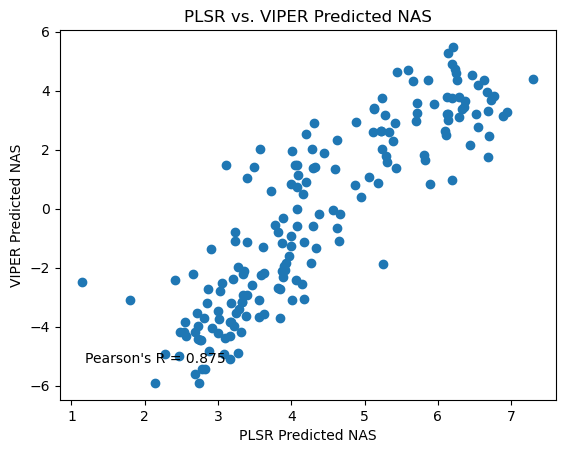

In [78]:
ax = plt.axes()
scatterNAS = ax.scatter(Y_hat_MPS["NAS"], Y_viper_MPS["NAS"])
ax.set_xlabel("PLSR Predicted NAS")
ax.set_ylabel("VIPER Predicted NAS")
ax.set_title("PLSR vs. VIPER Predicted NAS")
ax.annotate("Pearson's R = {:.3f}".format(pearsonr(Y_viper_MPS["NAS"], Y_hat_MPS["NAS"])[0]), xy=(0.05, 0.1), xycoords='axes fraction')
plt.savefig(f'graphs/MPS_NAS_prediction.png', dpi=200)

plt.show()

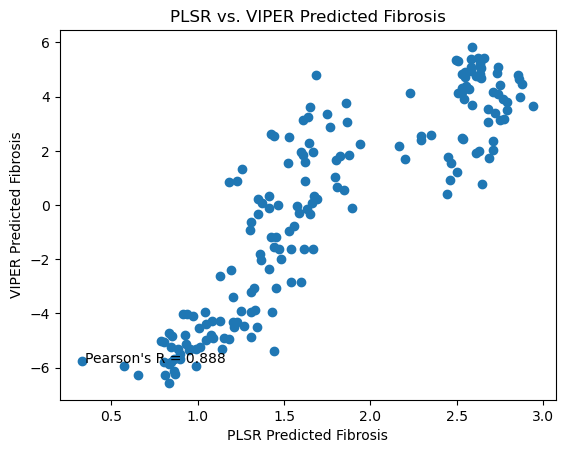

In [77]:
ax = plt.axes()
scatterFib = ax.scatter(Y_hat_MPS["Fibrosis"], Y_viper_MPS["Fibrosis stage"])
ax.set_xlabel("PLSR Predicted Fibrosis")
ax.set_ylabel("VIPER Predicted Fibrosis")
ax.set_title("PLSR vs. VIPER Predicted Fibrosis")
ax.annotate("Pearson's R = {:.3f}".format(pearsonr(Y_viper_MPS["Fibrosis stage"], Y_hat_MPS["Fibrosis"])[0]), xy=(0.05, 0.1), xycoords='axes fraction')
plt.savefig(f'graphs/MPS_Fib_prediction.png', dpi=200)
plt.show()